### Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

In [ ]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

**Drop duplicates**

In [ ]:
from datasets import Dataset

df = fashion.to_pandas()
df = df.drop_duplicates()
fashion = Dataset.from_pandas(df)
fashion

## Encoder Model

In [ ]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32',
    device=device)

In [ ]:
def dense_embed(batch):
  imgs = batch['image']
  dense_embed = model.encode(imgs)
  return {'dense_embed':dense_embed}
fashion = fashion.map(dense_embed,batched=True,batch_size=512)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image', 'metadata', 'sparse_embed', 'dense_embed'],
    num_rows: 44072
})

## Dense Search

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

top_k = 10 # N° of retirived products from the DB

**Dense embeddings of the data**

In [ ]:
dense_embeds  = np.array(fashion['dense_embed']) # DB in memeory that stores the embeddings of the products
dense_embeds.shape

(44072, 512)

### Text search

In [ ]:
query = "dark blue french connection jeans for men"

dense_query = model.encode(query)[np.newaxis,...]
dense_query.shape

(1, 512)

In [ ]:
dense_scores = cosine_similarity(dense_query, dense_embeds).flatten()
top_indices = np.argsort(dense_scores)[-top_k:][::-1]
top_scores = dense_scores[top_indices]

top_results = fashion.select(top_indices)
top_results

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image', 'metadata', 'sparse_embed', 'dense_embed'],
    num_rows: 10
})

In [ ]:
# function to display product images
def display_result(top_results):
    figures = []
    image_batch = top_results['image']
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <style>
          img:hover{{
            cursor:pointer;
          }}
        </style>
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


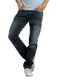
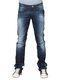
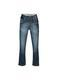
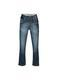
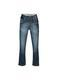
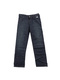
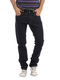
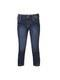
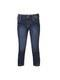
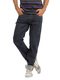

In [ ]:
display_result(top_results)

### Search by an image

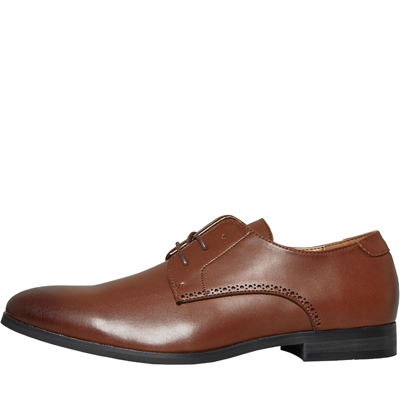

In [ ]:
query = Image.open('/content/pv30038_1_cloudzoom.jpg')
query.resize((400,400))

In [ ]:
dense_query = model.encode(query)[np.newaxis,...]
dense_query.shape

(1, 512)

[0.90835381 0.89549459 0.89256879 0.89100659 0.89085542 0.88965739
 0.88839906 0.88810932 0.88788734 0.88760221]



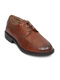
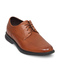
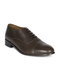
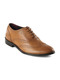
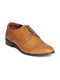
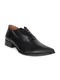
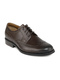
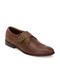
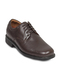
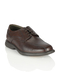

In [ ]:
dense_scores = cosine_similarity(dense_query, dense_embeds).flatten()
top_indices = np.argsort(dense_scores)[-top_k:][::-1]
top_scores = dense_scores[top_indices]
print(top_scores)
top_results = fashion.select(top_indices)
display_result(top_results)

$$$$